## (Project name)

### Group member: Elaine Zhang, Xintong Zheng, Xi Yan

Description:

In [84]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
%matplotlib inline
plt.style.use('seaborn-white')

In [85]:
# Import ML packages
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.datasets import load_nfl
from yellowbrick.datasets import load_credit
from yellowbrick.datasets import load_hobbies
from sklearn.datasets import make_blobs

### Question 1
1) Reading and Cleaning your dataset/s

a) Explore if your dataset/s has NAs and deal with them (or provide an explanation for keeping them and how you will deal with them moving forward)

b) If you are doing a classifier take note of how many data points per class you have.

c) Any other necessary conversation such as dealing with categorical variables, verifying each variable is the right type.

d) If you have more than one dataset make sure to clean all of your datasets!

### Read and clean weather data
The weather data is retrieved from [National Centers for Environmental Information](https://www.ncdc.noaa.gov/cdo-web/search), ranged from Jan.1 2017 to Dec.31 2019, of a weather station located at Pittsburgh, PA, USA.

In [86]:
# Read weather csv file
weather = pd.read_csv("pit_weather.csv")
# Select only 5 columns from the initial dataset
weather = weather[['DATE', 'AWND', 'PRCP', 'TMAX', 'TMIN']]
# Calculate the average temperature of the day
weather['TAVG'] = weather[['TMAX', 'TMIN']].mean(axis=1)
# Show if there are any missing values
weather.info()
# However, we will not drop the NaN values now for the convenience of merging dataset
weather.isnull().sum(axis=0)
# Print the first 5 rows of the dataset
weather.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    1095 non-null   object 
 1   AWND    1092 non-null   float64
 2   PRCP    1094 non-null   float64
 3   TMAX    1093 non-null   float64
 4   TMIN    1093 non-null   float64
 5   TAVG    1093 non-null   float64
dtypes: float64(5), object(1)
memory usage: 51.5+ KB


,DATE,AWND,PRCP,TMAX,TMIN,TAVG
0,2017-01-01,5.82,0.03,44.0,32.0,38.0
1,2017-01-02,7.16,0.09,46.0,36.0,41.0
2,2017-01-03,6.93,0.76,50.0,42.0,46.0
3,2017-01-04,15.66,0.04,45.0,21.0,33.0
4,2017-01-05,8.72,0.06,23.0,18.0,20.5


### Read and clean ride rentals data
The ride rental data is retrieved from [Western Pennsylvania Regional Data Center](https://data.wprdc.org/dataset/healthyride-trip-data), since we are using 2017-2019 data, and the data is a .csv file quarterly. We have to combine 12 .csv data first in order to finish the cleaning.

In [87]:
ride = pd.DataFrame(data = None)
for i in range(7,10):
    for j in range(1,5):
        ride_1 = pd.read_csv("healthy-ride-rentals-201{}-q{}.csv".format(i, j))
        # drop the lines with NA
        ride_1 = ride_1.dropna(axis=0)
        # copy the column with date
        ride_1["tmp"] = ride_1["Starttime"]
        # starttime and stoptime delete the date
        ride_1["Starttime"] = ride_1["Starttime"].apply(lambda x: str(x).split(" ")[1])
        ride_1["Stoptime"] = ride_1["Stoptime"].apply(lambda x: str(x).split(" ")[1])
        # extract date to a new column and then merge with weather dataset
        ride_1["DATE"] = ride_1["tmp"].apply(lambda x: str(str(x).split("/")[2]).split(" ")[0] + "-" + str(x).split("/")[0]+ "-"  + str(x).split("/")[1])
        # adjust the format
        ride_1["DATE"] = pd.to_datetime(ride_1["DATE"]).apply(lambda x: str(x).split(" ")[0])
        # delete the temp column
        del ride_1["tmp"]

        # add each subdataset
        ride = pd.concat([ride, ride_1])
ride

/Users/nellyan45/.conda/envs/untitled/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,2,6,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Trip id,Starttime,Stoptime,Bikeid,Tripduration,From station id,From station name,To station id,To station name,Usertype,DATE
0,25723960.0,8:28,8:30,70478.0,110.0,1043.0,S Millvale Ave & Centre Ave,1044.0,Zulema St & Coltart Ave,Subscriber,2017-01-01
1,25724207.0,9:53,10:00,70439.0,426.0,1014.0,Ridge Ave & Brighton Rd (CCAC),1012.0,North Shore Trail & Fort Duquesne Bridge,Customer,2017-01-01
2,25724297.0,10:21,10:46,70440.0,1498.0,1019.0,42nd St & Butler St,1012.0,North Shore Trail & Fort Duquesne Bridge,Subscriber,2017-01-01
3,25724391.0,11:03,11:30,70002.0,1581.0,1019.0,42nd St & Butler St,1013.0,Isabella St & Federal St (PNC Park),Customer,2017-01-01
4,25724479.0,11:43,12:09,70024.0,1563.0,1018.0,Butler St & Stanton Ave,1013.0,Isabella St & Federal St (PNC Park),Customer,2017-01-01
...,...,...,...,...,...,...,...,...,...,...,...
19850,89029487.0,16:43,16:49,70340.0,347.0,1023.0,Liberty Ave & Baum Blvd,1043.0,S Millvale Ave & Centre Ave,Subscriber,2019-11-02
19851,89029593.0,16:47,16:51,70277.0,242.0,1018.0,Butler St & Stanton Ave,1019.0,42nd St & Butler St,Subscriber,2019-11-02
19852,89029810.0,16:56,17:28,70153.0,1952.0,1093.0,S Bouquet Ave & Sennott St,1036.0,Schenley Dr at Schenley Plaza (Carnegie Librar...,Customer,2019-11-02
19853,89031027.0,17:41,17:49,70536.0,479.0,1063.0,Penn Ave & N Atlantic Ave,49401.0,Stanton Ave & N Negley Ave,Subscriber,2019-11-02


1a. We will eliminate the NA data rows after merging the previous two datasets, since each row would be a record of the data of a trip that customer rided. By eliminating a row that has NA value it would not affect the overall dataset significantly, since we have over 200,000 rows (records) of rides that are sufficient enough to train our data.

1b. The classification we are trying to run will have two categories, one is subscriber, another one is customer.

1c. When we are predicting trip duration, there is 1 categorical variable, "Usertype", which differentiate Subscriber and Customer, that are needed to convert to a dummy variable.

### Question 2
2) Decide whether you are merging your datasets or keeping them separate.

a) If you are keeping your datasets separate provide a brief explanation of how you are going to use each dataset.

b) If you are joining your datasets check that you are not losing relevant data and you are joining your dataset correctly.


2. We are merging all of our datasets, since we are able to left merge ride rental data with weather that are based on the variable date. We might only lose a tiny portion of data due to the fact that the format of the variable date are exactly the same for ride rentals and weather, since the data for weather have only a few rows of missing value, the merged the dataset with 200,000 data would not lose over 0.1% of the data by dropping NaN.

### Merge datasets

In [88]:
# Merge ride dataframe with weather dataframe based on DATE
df_merged = pd.merge(ride, weather, on='DATE')
df_merged.info()
# Show how many rows have empty values
df_merged.isnull().sum(axis=0)
# Drop rows which contain NaN values
df_merged = df_merged.dropna()
# Drop not useful columns
df_merged = df_merged.drop(['Trip id', 'Bikeid','From station name', 'To station name'], axis=1)
# Convert Usertype from categorical to dummy variable 0(customer) and 1(subscriber)
df_merged['Usertype'] = df_merged['Usertype'].astype('category').cat.codes
# Show top 5 rows of the dataset
df_merged.head(5)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 227290 entries, 0 to 227289
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Trip id            227290 non-null  float64
 1   Starttime          227290 non-null  object 
 2   Stoptime           227290 non-null  object 
 3   Bikeid             227290 non-null  float64
 4   Tripduration       227290 non-null  float64
 5   From station id    227290 non-null  float64
 6   From station name  227290 non-null  object 
 7   To station id      227290 non-null  float64
 8   To station name    227290 non-null  object 
 9   Usertype           227290 non-null  object 
 10  DATE               227290 non-null  object 
 11  AWND               227006 non-null  float64
 12  PRCP               226736 non-null  float64
 13  TMAX               227215 non-null  float64
 14  TMIN               227215 non-null  float64
 15  TAVG               227215 non-null  float64
dtypes:

,Starttime,Stoptime,Tripduration,From station id,To station id,Usertype,DATE,AWND,PRCP,TMAX,TMIN,TAVG
0,8:28,8:30,110.0,1043.0,1044.0,1,2017-01-01,5.82,0.03,44.0,32.0,38.0
1,9:53,10:00,426.0,1014.0,1012.0,0,2017-01-01,5.82,0.03,44.0,32.0,38.0
2,10:21,10:46,1498.0,1019.0,1012.0,1,2017-01-01,5.82,0.03,44.0,32.0,38.0
3,11:03,11:30,1581.0,1019.0,1013.0,0,2017-01-01,5.82,0.03,44.0,32.0,38.0
4,11:43,12:09,1563.0,1018.0,1013.0,0,2017-01-01,5.82,0.03,44.0,32.0,38.0


### Question 3
3) Provide at least two initial visualizations that describe your data. These can be a correlation plot of all the variables, a boxplot or density plots of the variables, or even a plot specific to any of the questions you are trying to tackle.

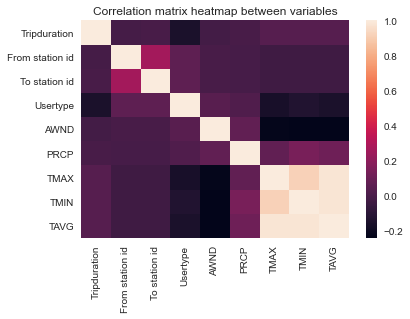

In [89]:
# Data visualization plots (first)
# This plot try to see the correlation between each features
corr = df_merged.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,).set_title('Correlation matrix heatmap between variables')
plt.show()

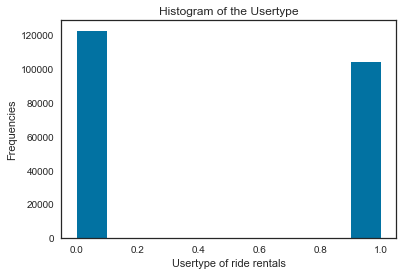

In [90]:
# Data visualization plots (second)
# This plot try to see the distribution of Usertype for ride rentals
plt.hist(df_merged['Usertype'])
plt.xlabel('Usertype of ride rentals')
plt.ylabel('Frequencies')
plt.title('Histogram of the Usertype')
plt.show()

### Question 4
4) Define your classification or prediction variables (if you're doing unsupervised learning).

We are trying to do both classification and prediction.

For prediction, the target variable we are going to predict is Tripduration.

For classification, the target variable we are going to classify is Usertype.


### Question 5
5) Define 3-4 questions you want to answer with your datasets.

1. What is the influence of weather on trip duration? Weather is examined by average wind speed, precipitation, maximum temperature, minimum temperature, and average temperature.
2. How does the trip start/stop locations influence on trip duration?
3. Do subscribers spend more time riding bikes than customers?
4. What are the top 5 most important features for classifying usertype?

### Question 6
6)Do a pre-liminary test. Train a model (prediction or classification) with your clean dataset. Report how good is this initial test.

We are doing a prediction on trip duration for this pre-liminary test.

In [94]:
# Split target and independent variable
X = df_merged.drop(['Tripduration', 'DATE'], axis=1)
y = df_merged['Tripduration']
# Set up train and test sets of data, train data is 70 percent of the dataset, and test is 30 percent.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [96]:
# Create linear regression model
lm = LinearRegression(normalize=True)
lm.fit(X_train, y_train)
# Generate target variable prediction
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)
# Get the Cross validation error based on negative MSE
CV_error_lm = np.mean(cross_val_score(lm, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
print('Train R^2 is', lm.score(X_train, y_train))
print('Test R^2 is', lm.score(X_test, y_test))
print('Train MSE is', mean_squared_error(y_train, y_train_pred))
print('Test MSE is', mean_squared_error(y_test, y_test_pred))
print('Cross Validation MSE for linear regression is', np.abs(CV_error_lm))

/Users/nellyan45/.conda/envs/untitled/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


ValueError: could not convert string to float: '18:21'